In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

calendar = pd.read_csv('calendar_seattle.csv')
listings = pd.read_csv('listings_seattle.csv')
reviews = pd.read_csv('reviews_seattle.csv')

num_vars = listings.select_dtypes(include=['float', 'int']).columns
cat_vars = listings.select_dtypes(include=['object']).columns

/tools/eb/software/Anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
cat_vars

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

In [3]:
num_vars

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [4]:
listings.shape

(3818, 92)

In [5]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype('float')
listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

In [6]:
#data exploration
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Broadway,397
Belltown,234
Wallingford,167
Fremont,158
Minor,135
University District,122
Stevens,119
First Hill,108
Central Business District,103


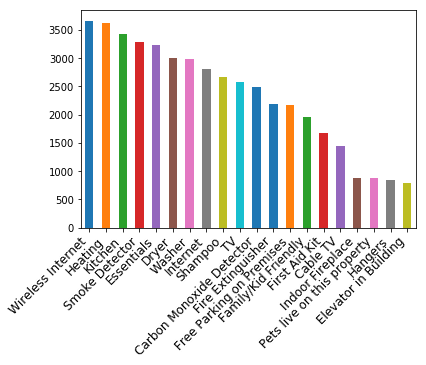

In [7]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")
pd.Series(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

In [8]:
listings[(listings.price> 400)].count()[['id']]/ listings.shape[0]

id    0.016501
dtype: float64

In [9]:
listings = listings.loc[(listings.price <=400) & (listings.price > 0)]

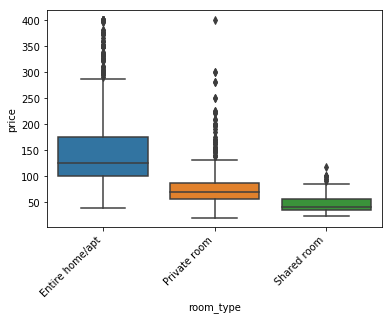

In [10]:
sort_price = listings.groupby('room_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='room_type', data=listings, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

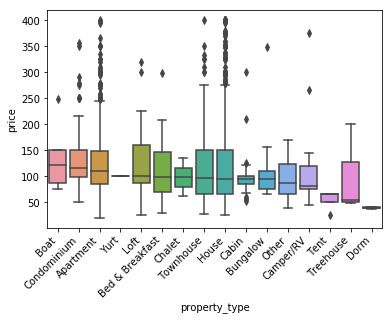

In [11]:
sort_price = listings.groupby('property_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='property_type', data=listings, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

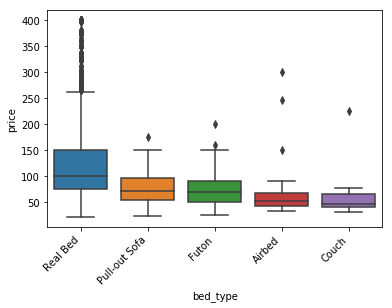

In [12]:
sort_price = listings.groupby('bed_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='bed_type', data=listings, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

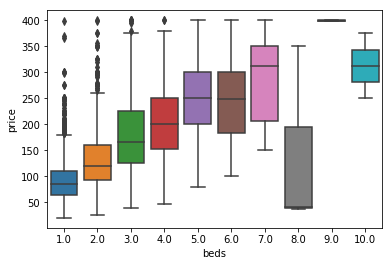

In [13]:
sns.boxplot(y='price', x='beds', data = listings)
plt.show();

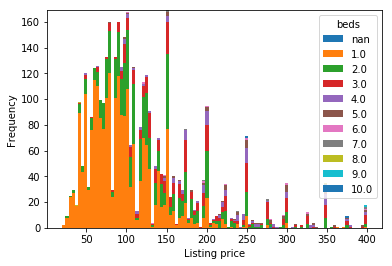

In [14]:
listings.pivot(columns = 'beds',values = 'price').plot.hist(stacked = True,bins=100)
plt.xlabel('Listing price');

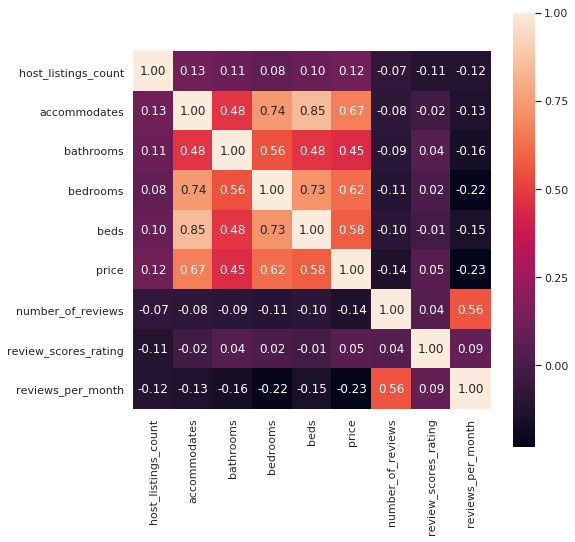

In [15]:
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']
corr = listings[col].dropna().corr()
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

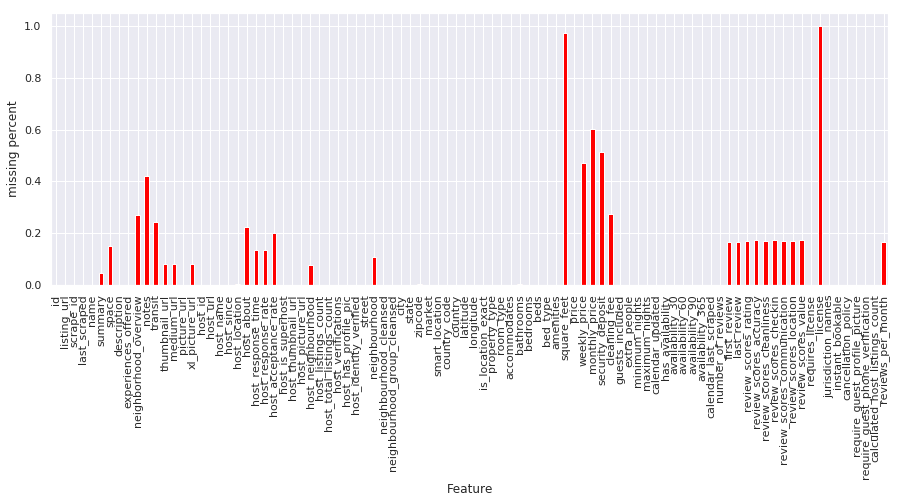

In [16]:
percentage_missing_data = listings.isnull().sum() / listings.shape[0]
ax = percentage_missing_data.plot(kind = 'bar', color='red', figsize = (15, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('missing percent')
plt.show()

In [17]:
#remove missing percent >40%
above40Miss = ['notes', 'square_feet', 'weekly_price','monthly_price', 'security_deposit',  'license']
listings.drop(above40Miss, axis=1, inplace=True)

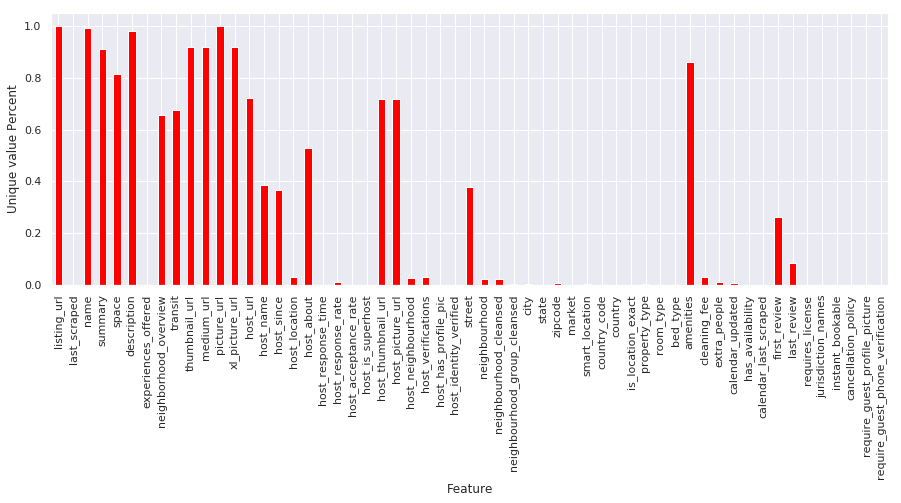

In [18]:
categories = listings.columns[listings.dtypes == 'object']
percentage_unique = listings[categories].nunique() / listings.shape[0]

ax = percentage_unique.plot(kind = 'bar', color='red', figsize = (15, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Unique value Percent')
plt.show()

In [19]:
# reomove features have a large number of unique values which require more NLP to further extract feature
large = ['listing_url', 'name','summary','space','description','neighborhood_overview',
          'transit', 'thumbnail_url', 'medium_url', 'picture_url','xl_picture_url', 'host_url', 
          'host_about','host_thumbnail_url', 'host_picture_url', 'street']# 'amenities']
listings.drop(large, axis=1, inplace=True)
# reomove features have single value
single=['last_scraped','experiences_offered', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country','calendar_last_scraped', 'has_availability',
       'requires_license', 'jurisdiction_names']
listings.drop(single, axis=1, inplace=True)
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace(',', '')
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace('$', '')
listings['cleaning_fee'] = listings['cleaning_fee'].astype('float')

In [20]:
#convert boolean varables to numeric
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact',  'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

In [21]:
#Fill the missing values in the numeric features with median
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact','instant_bookable' ,
                         'require_guest_phone_verification',  'cleaning_fee','host_listings_count', 'host_total_listings_count', 'minimum_nights',
                     'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews','review_scores_rating', 'price']]
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())
    
#get_dummies for categorical variables   
for cat_feature in [ 'property_type', 'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'bed_type']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

/tools/eb/software/Anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
#Train and make predictions with model
y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)


#Linear
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) 

#Predict using your model
y_test_pred_lm = lm_model.predict(X_test)
y_train_pred_lm = lm_model.predict(X_train)
rmse_lm= (mean_squared_error(y_test,y_test_pred_lm))**(1/2)
#Score using your model
test_score = r2_score(y_test, y_test_pred_lm)
train_score = r2_score(y_train, y_train_pred_lm)
print('\nLinear model RMSE test: %.3f' % rmse_lm)
print('Linear model R^2 test: %.3f' % (r2_score(y_test, y_test_pred_lm)))

#RandomForest model
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('\nRandom Forest RMSE test: %.3f' % rmse_rf)
print('Random Forest R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

#AdaBoostRegressor
ada = AdaBoostRegressor(random_state=42, n_estimators=100)
ada.fit(X_train, y_train)
y_train_pred_ada = ada.predict(X_train)
y_test_pred_ada = ada.predict(X_test)
rmse_ada= (mean_squared_error(y_test,y_test_pred_ada))**(1/2)

print('\nRandom Forest RMSE test: %.3f' % rmse_ada)
print('Random Forest R^2 test: %.3f' % (r2_score(y_test, y_test_pred_ada)))




Linear model RMSE test: 27014295956981.453
Linear model R^2 test: -152932941152324056776704.000

Random Forest RMSE test: 42.367
Random Forest R^2 test: 0.624

Random Forest RMSE test: 60.685
Random Forest R^2 test: 0.228


In [23]:
#since Random Forest R^2 have highest value, so chose it
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
11,bedrooms,0.436578
31,Entire home/apt,0.078332
6,cleaning_fee,0.061203
10,bathrooms,0.041732
13,number_of_reviews,0.030530
14,review_scores_rating,0.021726
12,guests_included,0.016663
8,host_total_listings_count,0.016092
7,host_listings_count,0.015976
9,minimum_nights,0.014325
